In [1]:
# Temperature estimation using LSTM 
# dataset were given in the form of a CSV file

In [2]:
# importing libraries to do the mathematical calculations, read csv, plot the datasets and to execute the LSTM 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

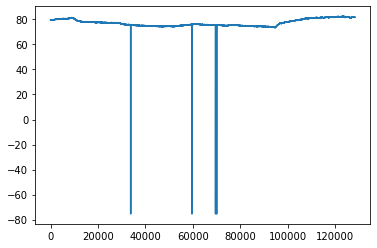

In [3]:

# load the dataset
# since the datasets didn't have any labels, we give the index name using colnames fucntion 
# and select the column using usecol1 =[1]
colnames = ['DateTime', 'Temp']
dataframe = read_csv('temperature_data.csv', names = colnames, usecols=[1], header =None)
plt.plot(dataframe,color='tab:blue')


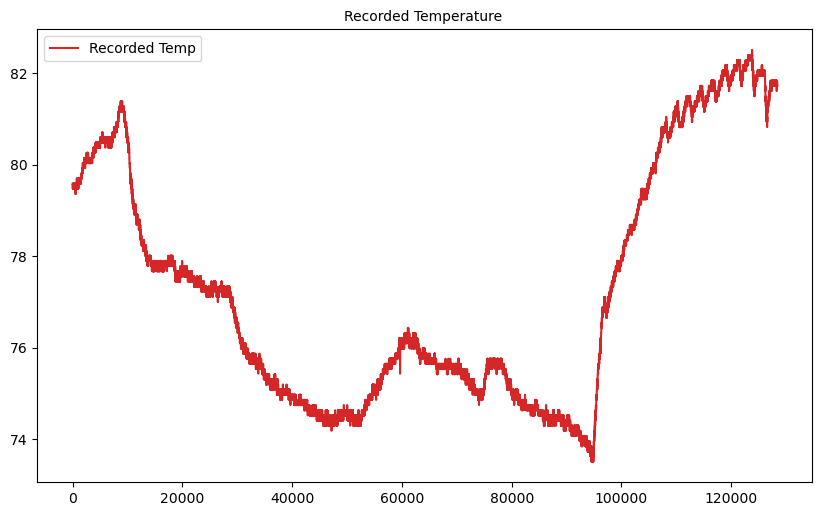

In [4]:
# So now we can clearly see that the temperature datasets contains negative value which is impossible to occur because the datasets have been recorded for every second
# So we convert the data of Temp column to positive using abs() function
dataframe ['Temp'] = dataframe['Temp'].abs()

# Now we plot the datasets with the figure size of 14,8 with dpi of 100
plt.figure(figsize=(10,6), dpi=100)
plt.title('Recorded Temperature ', size=10)
plt.plot(dataframe,color='tab:red',label='Recorded Temp')
plt.legend()

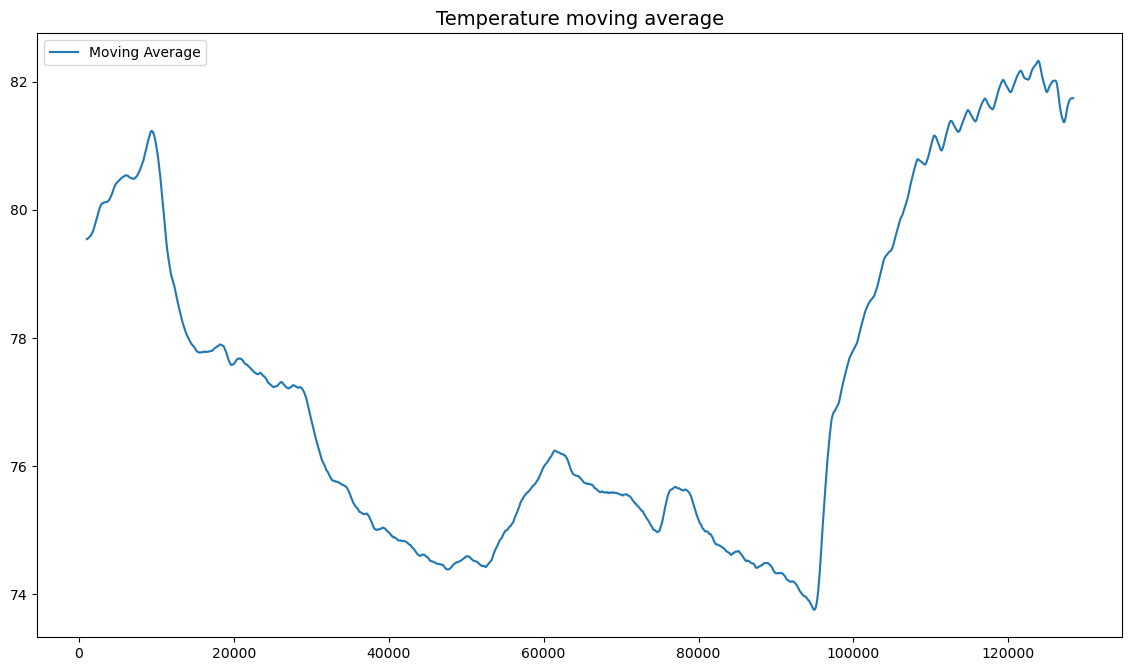

In [5]:
# As we can see the graph above is very jaggered and is difficult to understand the trend of the Temperature so we use Moving Average to smoothen-out the graph to get a better understaning
# first we create a df_mean and then select the Temp column of the df and then declare .rolling(window=1000).mean()
# this means we find Moving average of every 1000 seconds and then plot it.

dataframe_mean = dataframe.Temp.rolling(window=1000).mean()
plt.figure(figsize=(14,8),dpi=100)
plt.title('Temperature moving average', size=14)
plt.plot(dataframe_mean, label='Moving Average')
plt.legend()

In [6]:
# From we are going to the mathematical side of the Estimation so in order to do that we need to convert the pandas dataframe to numpy array (i.e)float32
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

In [7]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized so we use the MinMaxScalar to do that
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [8]:
#We cannot use random way of splitting dataset into train and test as the sequence of events is important for time series.
#So let us take first 75% values for train and the remaining for testing
# split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [9]:

# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as input variables to predict the next time period.

#creates a dataset where X is the number of temperature reading at a given time (t, t-1, t-2...) 
#and Y is the number of readings at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))


Shape of training set: (96275, 10)
Shape of test set: (32085, 10)


In [10]:
#ConvLSTM
#The layer expects input as a sequence of two-dimensional images, 
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 64)          19200     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [11]:
#  fitting the trainx and train values in the model
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)


Epoch 1/100
3009/3009 - 6s - loss: 2.8117e-04 - val_loss: 4.8456e-05 - 6s/epoch - 2ms/step
Epoch 2/100
3009/3009 - 5s - loss: 3.1835e-05 - val_loss: 1.7350e-04 - 5s/epoch - 2ms/step
Epoch 3/100
3009/3009 - 5s - loss: 3.2384e-05 - val_loss: 2.4918e-05 - 5s/epoch - 2ms/step
Epoch 4/100
3009/3009 - 5s - loss: 3.0879e-05 - val_loss: 2.5455e-05 - 5s/epoch - 2ms/step
Epoch 5/100
3009/3009 - 5s - loss: 3.1413e-05 - val_loss: 3.6556e-05 - 5s/epoch - 2ms/step
Epoch 6/100
3009/3009 - 4s - loss: 3.1212e-05 - val_loss: 2.4338e-05 - 4s/epoch - 1ms/step
Epoch 7/100
3009/3009 - 4s - loss: 3.0866e-05 - val_loss: 4.1050e-05 - 4s/epoch - 1ms/step
Epoch 8/100
3009/3009 - 4s - loss: 3.0188e-05 - val_loss: 4.2174e-05 - 4s/epoch - 1ms/step
Epoch 9/100
3009/3009 - 5s - loss: 3.0769e-05 - val_loss: 6.5546e-05 - 5s/epoch - 2ms/step
Epoch 10/100
3009/3009 - 5s - loss: 3.0154e-05 - val_loss: 2.5405e-05 - 5s/epoch - 2ms/step
Epoch 11/100
3009/3009 - 5s - loss: 3.0066e-05 - val_loss: 2.5014e-05 - 5s/epoch - 2ms/st

Epoch 91/100
3009/3009 - 5s - loss: 2.7468e-05 - val_loss: 2.4793e-05 - 5s/epoch - 2ms/step
Epoch 92/100
3009/3009 - 5s - loss: 2.7964e-05 - val_loss: 4.9107e-05 - 5s/epoch - 2ms/step
Epoch 93/100
3009/3009 - 5s - loss: 2.7882e-05 - val_loss: 5.5783e-05 - 5s/epoch - 2ms/step
Epoch 94/100
3009/3009 - 5s - loss: 2.7670e-05 - val_loss: 7.6084e-05 - 5s/epoch - 2ms/step
Epoch 95/100
3009/3009 - 5s - loss: 2.7813e-05 - val_loss: 2.3868e-05 - 5s/epoch - 2ms/step
Epoch 96/100
3009/3009 - 5s - loss: 2.7689e-05 - val_loss: 2.7959e-05 - 5s/epoch - 2ms/step
Epoch 97/100
3009/3009 - 5s - loss: 2.7708e-05 - val_loss: 3.5879e-05 - 5s/epoch - 2ms/step
Epoch 98/100
3009/3009 - 5s - loss: 2.7682e-05 - val_loss: 2.4046e-05 - 5s/epoch - 2ms/step
Epoch 99/100
3009/3009 - 5s - loss: 2.7969e-05 - val_loss: 2.5509e-05 - 5s/epoch - 2ms/step
Epoch 100/100
3009/3009 - 5s - loss: 2.7880e-05 - val_loss: 2.6618e-05 - 5s/epoch - 2ms/step


In [12]:
# making predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [13]:
# invert predictions back to prescaled values
#This is to compare with original input values
#Since we used minmaxscaler we can now use scaler.inverse_transform to invert the transformation.

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [14]:
# calculate root mean squared error
# The lower the RMSE value the more accurate the model is

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.05 RMSE
Test Score: 0.05 RMSE


In [15]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict



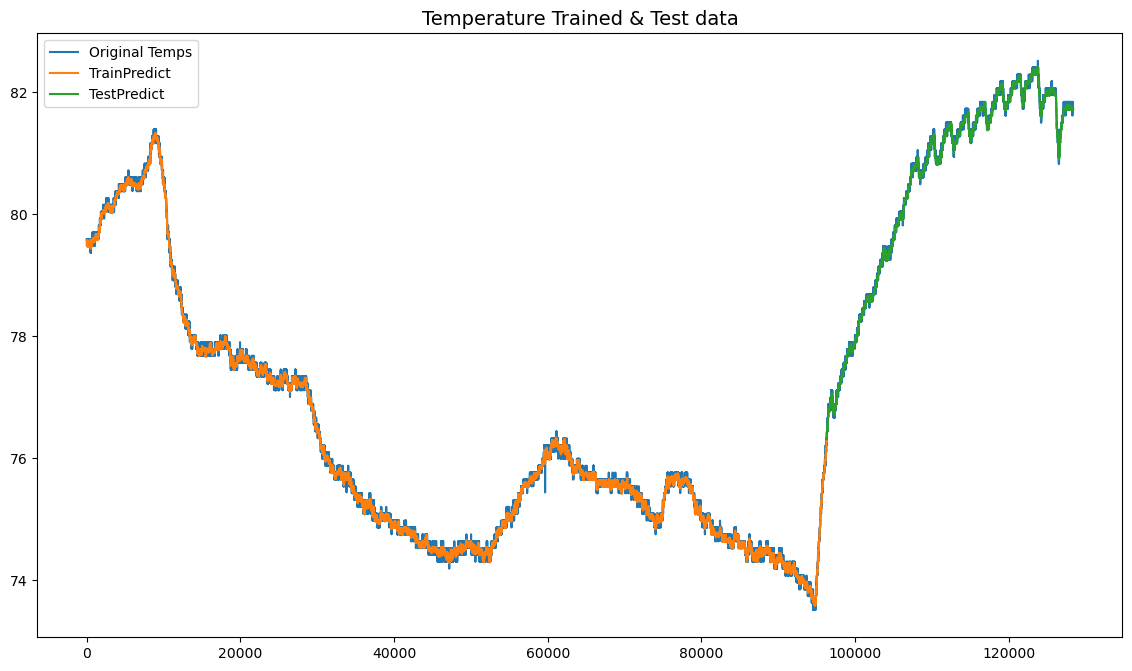

In [16]:
# plot baseline and predictions
plt.figure(figsize=(14,8), dpi=100)
plt.title('Temperature Trained & Test data', size=14)
plt.plot(scaler.inverse_transform(dataset),label='Original Temps')
plt.plot(trainPredictPlot,label='TrainPredict')
plt.plot(testPredictPlot,label='TestPredict')
plt.legend()

In [17]:
# As we are done with our Train and Test plotting ,we can see that it alings with the original datasets
# but still the plotting looks jaggered can sometimes be misleading because we are dealing with thousands of data so we need a
# more clear picture of the test and train datasets.
# so now we will be looking at the moving average of the Train and Test datasets 
# inorder to do that first we need to convert numPy array to pandas
# (i.e) convert trainPredictPlot, testPredictPlot back to a Dataframe and save it into a new df

trainPredictPlot_df = pd.DataFrame(trainPredictPlot,columns=['Temp'])

testPredictPlot_df = pd.DataFrame(testPredictPlot,columns=['Temp'])

print(trainPredictPlot_df,testPredictPlot_df)

        Temp
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
...      ...
128377   NaN
128378   NaN
128379   NaN
128380   NaN
128381   NaN

[128382 rows x 1 columns]              Temp
0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
...           ...
128377  81.712013
128378  81.712006
128379  81.712006
128380  81.712006
128381        NaN

[128382 rows x 1 columns]


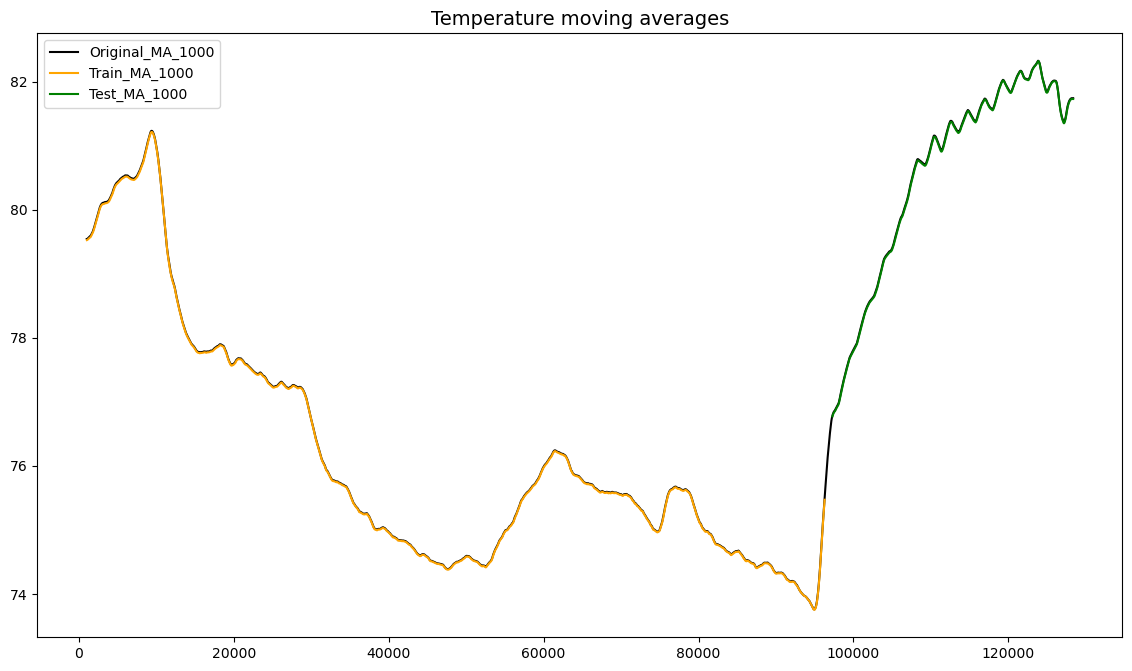

In [18]:
# Now we will be Plotting the Moving averages of the oridinal dataframe, TrainPredict, TestPredict and will be comparing it

plt.figure(figsize=(14,8),dpi=100)
plt.title('Temperature moving averages', size=14)

dataframe_mean = dataframe['Temp'].rolling(window=1000).mean()
plt.plot(dataframe_mean, color='Black', label='Original_MA_1000')

TrainPredict_mean = trainPredictPlot_df['Temp'].rolling(window=1000).mean()
plt.plot(TrainPredict_mean, color='orange', label='Train_MA_1000')

TestPredict_mean = testPredictPlot_df['Temp'].rolling(window=1000).mean()
plt.plot(TestPredict_mean, color='green', label='Test_MA_1000')

plt.legend()